<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%EC%9D%B4%EC%83%81%EC%B9%98%20%ED%83%90%EC%A7%80%20%EA%B8%B0%EB%B0%98%20%EB%8C%80%EC%B6%9C%20%EC%97%B0%EC%B2%B4%EC%9E%90%20%EC%A0%81%EB%B0%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/Autoencoder%20%EB%AA%A8%EB%8D%B8%20(PCA%20%EA%B8%B0%EB%B0%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# About Dataset

In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/BADA/1116_임시/anomaly_detecting.csv', index_col=0)
raw_df = raw_df.iloc[:, 1:]
raw_df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
raw_df.replace('XNA', np.nan, inplace=True)

In [ ]:
raw_df_na = pd.DataFrame(raw_df.isnull().sum(), columns=['Na'])
raw_df_na

,Na
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,4
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519


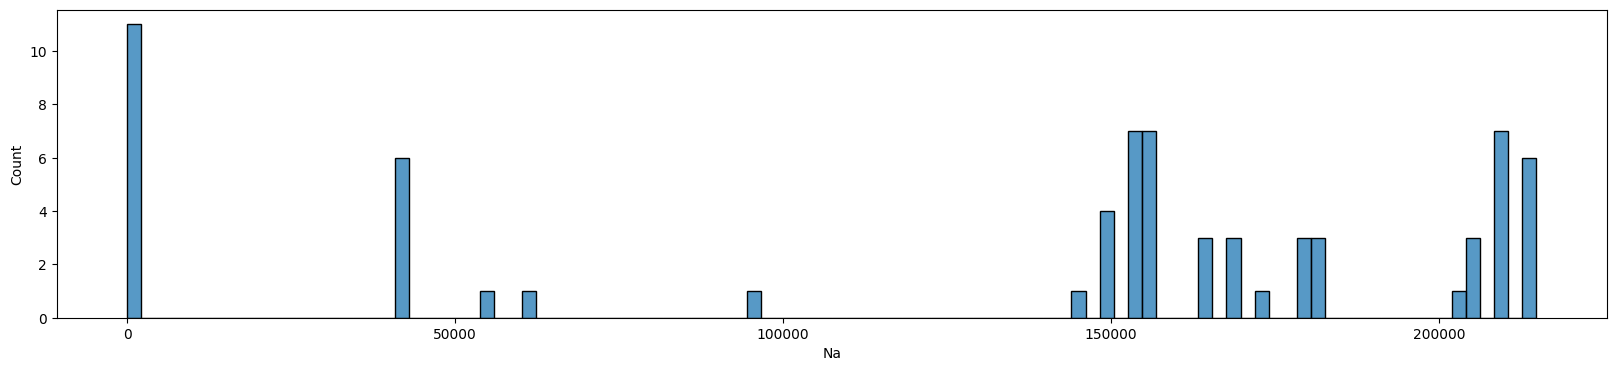

In [ ]:
plt.figure(figsize=(20,4))
sns.histplot(x='Na', data = raw_df_na[raw_df_na['Na'] != 0], bins = 100);

In [ ]:
remove_col = list(raw_df_na[raw_df_na['Na'] >= 10000].index)

new_df = raw_df.drop(labels=remove_col, axis=1)
new_df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = new_df['TARGET']
X = new_df.drop(labels='TARGET', axis=1)

# 데이터 형식 바꾸기

In [ ]:
category_list = list(X.dtypes[X.dtypes == 'object'].index)
numerical_list = list(X.dtypes[X.dtypes == 'int64'].index) + list(X.dtypes[X.dtypes == 'float64'].index)

In [ ]:
X['CODE_GENDER'].replace({'F': 1, 'M': 0}, inplace = True)
X['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace = True)
X['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0}, inplace = True)
X['NAME_CONTRACT_TYPE'].replace({'Cash loans':1,'Revolving loans':0}, inplace = True)
X['NAME_TYPE_SUITE'].replace({'Unaccompanied':0, 'Family':1, 'Spouse, partner':2, 'Children':3, 'Other_A':4,'Other_B':5, 'Group of people':6}, inplace = True)
X['NAME_INCOME_TYPE'].replace({'Working':0, 'State servant':1, 'Commercial associate':2, 'Pensioner':3, 'Unemployed':4,'Student':5, 'Businessman':6, 'Maternity leave':7}, inplace = True)
X['NAME_EDUCATION_TYPE'].replace({'Secondary / secondary special':0, 'Higher education':1, 'Incomplete higher':2, 'Lower secondary':3, 'Academic degree':4}, inplace = True)
X['NAME_FAMILY_STATUS'].replace({'Single / not married':0, 'Married':1, 'Civil marriage':2, 'Widow':3, 'Separated':4, 'Unknown':5}, inplace = True)
X['NAME_HOUSING_TYPE'].replace({'House / apartment':0, 'Rented apartment':1, 'With parents':2, 'Municipal apartment':3, 'Office apartment':4, 'Co-op apartment':5}, inplace = True)
X['WEEKDAY_APPR_PROCESS_START'].replace({'WEDNESDAY':0, 'MONDAY':1, 'THURSDAY':2, 'SUNDAY':3, 'SATURDAY':4, 'FRIDAY':5, 'TUESDAY':6}, inplace = True)

# 결측치 제거

In [ ]:
from sklearn.impute import SimpleImputer

#평균으로 Imputer 선언
imputer_mean = SimpleImputer(strategy='mean')
imputer_mean.fit(X[numerical_list])

X[numerical_list] = pd.DataFrame(imputer_mean.transform(X[numerical_list]))

In [ ]:
#최빈값으로 Imputer 선언
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_mode.fit(X[category_list])

X[category_list]  = imputer_mode.transform(X[category_list] )

In [ ]:
X[category_list] = X[category_list].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 62 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   NAME_CONTRACT_TYPE           307511 non-null  category
 1   CODE_GENDER                  307511 non-null  category
 2   FLAG_OWN_CAR                 307511 non-null  category
 3   FLAG_OWN_REALTY              307511 non-null  category
 4   CNT_CHILDREN                 307511 non-null  float64 
 5   AMT_INCOME_TOTAL             307511 non-null  float64 
 6   AMT_CREDIT                   307511 non-null  float64 
 7   AMT_ANNUITY                  307511 non-null  float64 
 8   AMT_GOODS_PRICE              307511 non-null  float64 
 9   NAME_TYPE_SUITE              307511 non-null  category
 10  NAME_INCOME_TYPE             307511 non-null  category
 11  NAME_EDUCATION_TYPE          307511 non-null  category
 12  NAME_FAMILY_STATUS           307511 non-null

In [ ]:
(X.isna().sum() != 0).sum()

0

In [ ]:
#Target 변수 변환
y[y=='.'] = np.nan
y.value_counts()

0    105347
1      9341
0      4880
1       433
Name: TARGET, dtype: int64

# Splitting Dataset

In [ ]:
# PCA 결과로 변수 17개만 남기기
X = X[['WEEKDAY_APPR_PROCESS_START', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_TYPE_SUITE', 'FLAG_EMP_PHONE',
       'NAME_EDUCATION_TYPE', 'REG_CITY_NOT_WORK_CITY',
       'CODE_GENDER', 'FLAG_DOCUMENT_3',
       'DAYS_EMPLOYED', 'FLAG_PHONE',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_WORK_PHONE', 'LIVE_CITY_NOT_WORK_CITY',
       'REGION_RATING_CLIENT']]

In [ ]:
#학습에 사용할 train set, 예측에만 사용할 test set으로 구분
X_train = X[X.index <= 120000]
X_test = X[X.index >= 120001]
y_train = y[y.index <= 120000]
y_test = y[y.index >= 120001]

In [ ]:
y_train = y_train.astype('int64')
y_train.value_counts()

0    110227
1      9774
Name: TARGET, dtype: int64

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120001, 17) (187510, 17) (120001,) (187510,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

# Scaling

In [ ]:
numerical_list1 = ['FLAG_EMP_PHONE',
       'REG_CITY_NOT_WORK_CITY',
       'FLAG_DOCUMENT_3',
       'DAYS_EMPLOYED', 'FLAG_PHONE',
       'FLAG_WORK_PHONE', 'LIVE_CITY_NOT_WORK_CITY',
       'REGION_RATING_CLIENT']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

## 입력데이터의 수치형 변수에 대해 Minmaxscaler 적용
scaler = MinMaxScaler()
X_train[numerical_list1] = scaler.fit_transform(X_train[numerical_list1])
X_valid[numerical_list1] = scaler.fit_transform(X_valid[numerical_list1])
X_test[numerical_list1] = scaler.fit_transform(X_test[numerical_list1])


## 정규화된 데이터를 tf.float64 데이터 타입으로 변환
X_train = tf.cast(X_train, tf.float64)
X_valid = tf.cast(X_valid, tf.float64)
X_test = tf.cast(X_test, tf.float64)

In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(108000, 17) (12001, 17) (187510, 17) (108000,) (12001,) (187510,)


✅test는 건들지 말것!!!

# 정상, 비정상 데이터 구분하기

In [ ]:
## 1(연체)을 True로 변환

y_train = y_train.astype(bool)
y_valid = y_valid.astype(bool)

print("the length of train :", len(y_train))
print("the length of valid :", len(y_valid))

the length of train : 108000
the length of valid : 12001


In [ ]:
X_train[~np.array(y_train)]

<tf.Tensor: shape=(99177, 17), dtype=float64, numpy=
array([[2. , 3. , 1. , ..., 0. , 0. , 0.5],
       [6. , 2. , 4. , ..., 1. , 0. , 0.5],
       [1. , 0. , 1. , ..., 0. , 0. , 0.5],
       ...,
       [1. , 0. , 1. , ..., 1. , 1. , 0.5],
       [0. , 2. , 4. , ..., 1. , 0. , 1. ],
       [5. , 0. , 1. , ..., 0. , 0. , 0. ]])>

In [ ]:
## 정상 데이터 만들기
normal_X_train = X_train[~np.array(y_train)]  #0인 경우
normal_X_valid = X_valid[~np.array(y_valid)]

## 비정상 데이터 만들기
anomalous_X_train = X_train[np.array(y_train)]  #1인 경우
anomalous_X_valid = X_valid[np.array(y_valid)]

In [ ]:
print(normal_X_train.shape, normal_X_valid.shape, anomalous_X_train.shape, anomalous_X_valid.shape)

(99177, 17) (11050, 17) (8823, 17) (951, 17)


# Modeling

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# TensorFlow의 Model 클래스를 기반으로 커스텀 모델인 AnomalyDetector를 정의
class AnomalyDetector(Model):

    def __init__(self):
        #상위 클래스인 Model 클래스의 생성자 호출
        super(AnomalyDetector, self).__init__()

        ## Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="tanh"),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(8, activation="elu"),
            layers.BatchNormalization(),
            layers.Dense(2, activation="relu"),
            layers.BatchNormalization()
        ])

        ## Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation="elu"),
            layers.BatchNormalization(),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(64, activation="tanh"),
            layers.BatchNormalization(),
            layers.Dense(17, activation="sigmoid"),  #출력층
            layers.BatchNormalization()
        ])

    ##forward pass 정의
    def call(self, x):
        #입력 x를 인코더에 전달하여 인코딩된 특성을 추출
        encoded = self.encoder(x)
        #인코딩된 특성을 디코더에 전달하여 디코딩된 출력을 생성
        decoded = self.decoder(encoded)
        return decoded


model_name = "anomaly.h5"
## ModelCheckpoint: 'val_loss'를 모니터링해, 이 값이 개선될 때마다 모델 가중치 저장
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",  #모니터링할 지표
                            mode="min",  #모델을 저장할 때 val_loss를 최소화하도록 설정
                            save_best_only = True,  #val_loss가 감소할 때만 모델을 저장
                            save_weights_only=True,  #모델 아키텍처와 관련된 정보를 저장하지 않고 모델 가중치만 저장
                            verbose=0)  #모델 저장 과정을 화면에 출력


## Early Stopping: 검증 손실값이 5에폭 동안 향상이 없으면 조기 종료
earlystopping = EarlyStopping(monitor='val_loss',  #모니터링할 지표
                              min_delta = 0,  #개선으로 간주하기 위한 최소 변화량
                              patience = 8,  #val_loss가 개선되지 않더라도 몇 번의 epoch를 기다릴지
                              verbose = 1,  #조기 종료 과정을 화면에 출력
                              restore_best_weights=True)  #조기 종료 후 최상의 성능을 보인 모델 가중치로 복원


## 체크포인트와 조기 종료 콜백을 저장
callbacks = [checkpoint, earlystopping]

autoencoder = AnomalyDetector()


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)
autoencoder.compile(optimizer=optimizer, loss='mae')


history = autoencoder.fit(normal_X_train, normal_X_train,
          epochs=150,
          batch_size=128,
          validation_data=(X_valid, X_valid),
          callbacks = callbacks,
          shuffle=False)

Epoch 1/150
775/775 [==============================] - 12s 6ms/step - loss: 0.9368 - val_loss: 0.8145
Epoch 2/150
775/775 [==============================] - 5s 7ms/step - loss: 0.7873 - val_loss: 0.7337
Epoch 3/150
775/775 [==============================] - 7s 9ms/step - loss: 0.7044 - val_loss: 0.6522
Epoch 4/150
775/775 [==============================] - 5s 6ms/step - loss: 0.6358 - val_loss: 0.5995
Epoch 5/150
775/775 [==============================] - 5s 6ms/step - loss: 0.5805 - val_loss: 0.5526
Epoch 6/150
775/775 [==============================] - 7s 9ms/step - loss: 0.5284 - val_loss: 0.5058
Epoch 7/150
775/775 [==============================] - 5s 6ms/step - loss: 0.4807 - val_loss: 0.4598
Epoch 8/150
775/775 [==============================] - 4s 6ms/step - loss: 0.4423 - val_loss: 0.4248
Epoch 9/150
775/775 [==============================] - 7s 9ms/step - loss: 0.4189 - val_loss: 0.4018
Epoch 10/150
775/775 [==============================] - 5s 6ms/step - loss: 0.4011 - val_l

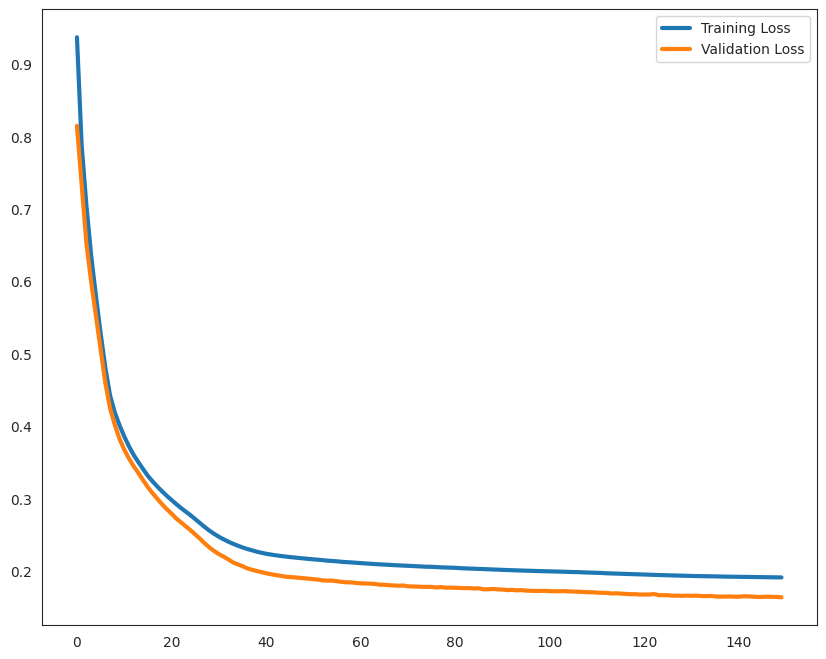

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss", linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=3.0)
plt.legend();

# Testing using normal data

In [ ]:
#인코딩된 데이터를 넘파이 배열로 변환
encoded_data = autoencoder.encoder(normal_X_valid).numpy()
#디코딩된 데이터를 넘파이 배열로 변환
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [ ]:
encoded_data_normal = pd.DataFrame(encoded_data)
encoded_data_normal['label'] = 0
encoded_data_normal

,0,1,2,label
0,0.216658,-0.369156,2.410707,0
1,-0.249279,-0.369156,-0.949184,0
2,0.229759,-0.369156,-0.846620,0
3,-0.833230,-0.369156,-0.949184,0
4,-0.253766,-0.369156,-0.326165,0
...,...,...,...,...
11045,-0.416143,-0.369156,-0.888541,0
11046,-0.830548,-0.368777,-0.949184,0
11047,-0.249207,-0.369156,-0.949184,0
11048,-0.535200,-0.029020,0.132137,0


# Testing using abnormal data

In [ ]:
encoded_data = autoencoder.encoder(anomalous_X_valid).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [ ]:
encoded_data_abnormal = pd.DataFrame(encoded_data)
encoded_data_abnormal['label'] = 1
encoded_data_abnormal

,0,1,2,label
0,-0.412607,-0.369156,-0.932919,1
1,-0.127423,1.772114,-0.013726,1
2,-0.567297,-0.369156,-0.949184,1
3,-0.415196,-0.369156,-0.937556,1
4,-0.584950,-0.369156,-0.949184,1
...,...,...,...,...
946,-1.084937,-0.334297,-0.949184,1
947,-0.419018,-0.369156,-0.949184,1
948,0.201192,-0.369156,0.093847,1
949,-0.252451,-0.369156,-0.871850,1


# Detecting Anomaly

In [ ]:
reconstructions = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mae(reconstructions, normal_X_train)

3100/3100 [==============================] - 9s 3ms/step


In [ ]:
np.mean(train_loss)

0.16371399904256825

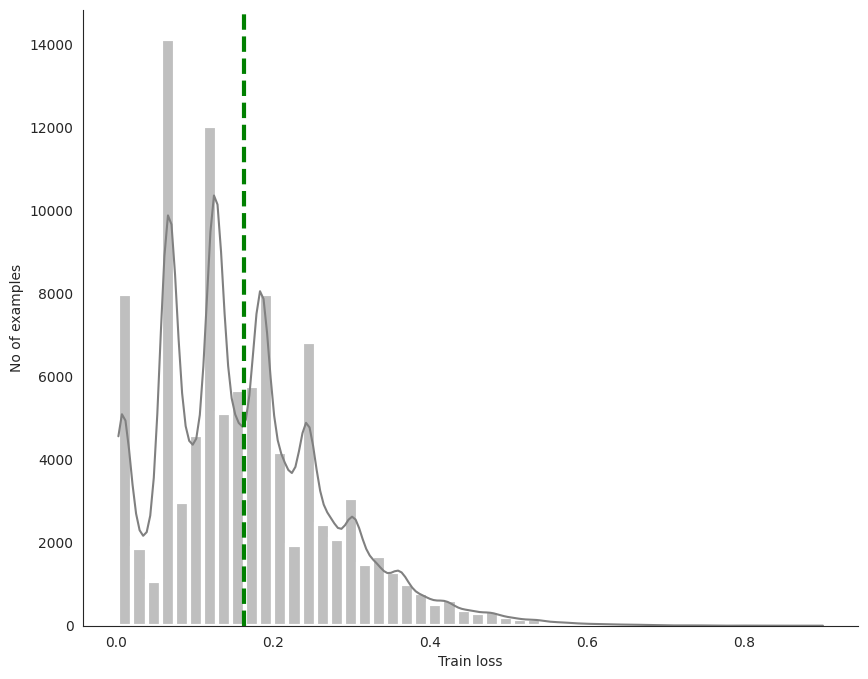

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.2710078355829637


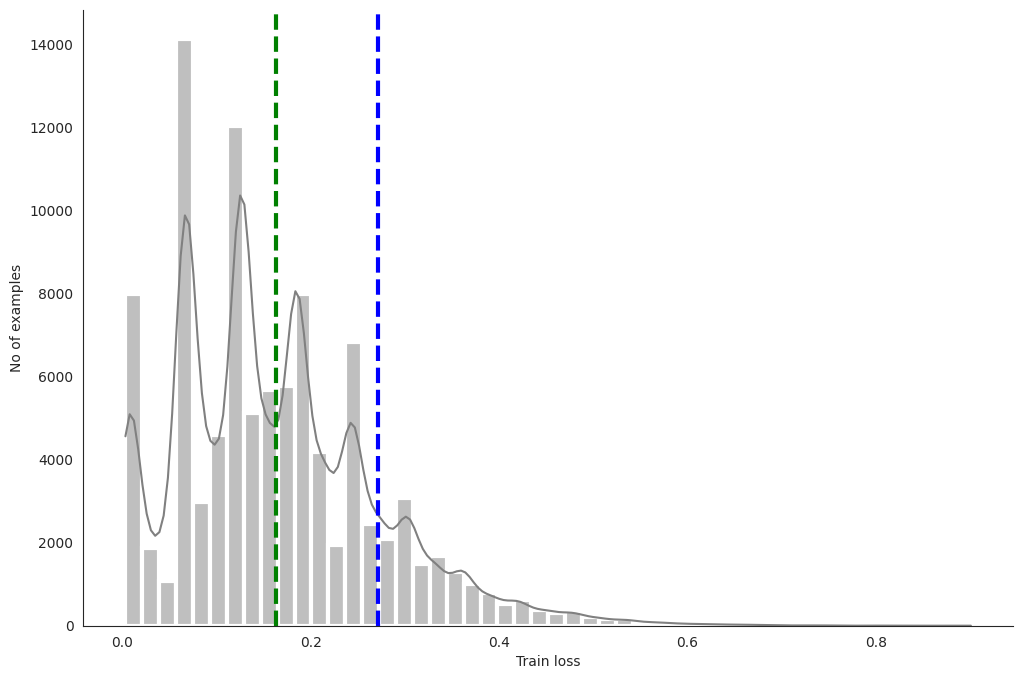

In [ ]:
plt.figure(figsize=(12,8))
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, color='grey', linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [ ]:
reconstructions = autoencoder.predict(anomalous_X_valid)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_X_valid)

30/30 [==============================] - 0s 3ms/step


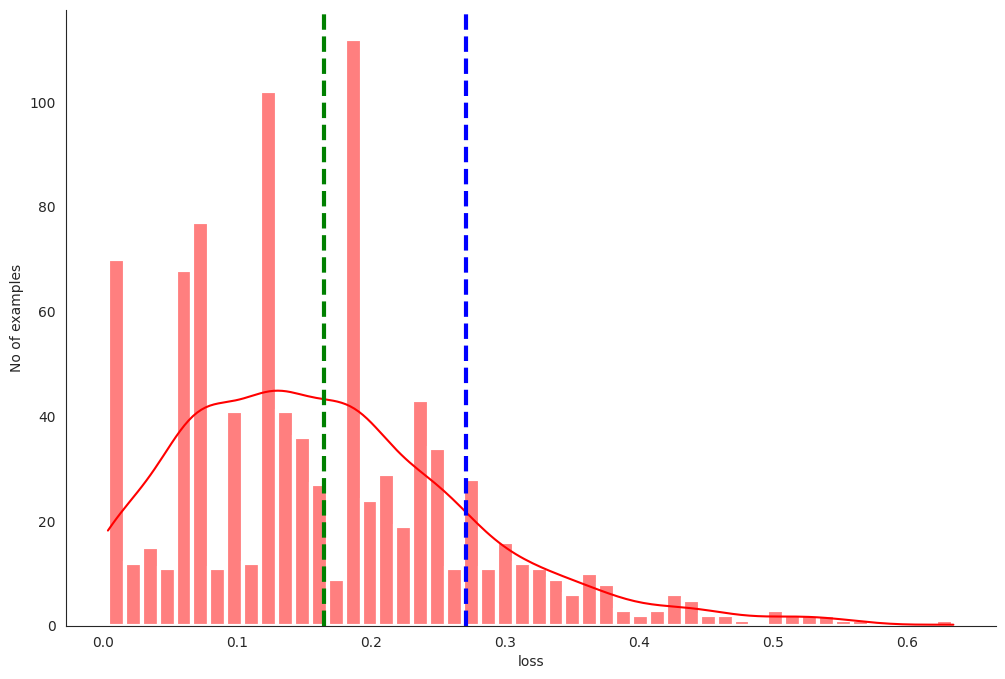

In [ ]:
plt.figure(figsize=(12,8))
sns.set_style("white")
sns.histplot(test_loss, bins=50, kde=True, color='red', linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

# Predicting

In [ ]:
def predict(model, data, threshold):
    #주어진 모델을 사용하여 입력 데이터의 재구성을 생성
    reconstructions = model(data)
    #재구성 손실 계산
    loss = tf.keras.losses.mae(reconstructions, data)
    #재구성 손실이 임계값보다 크면 True 반환
    return tf.math.greater(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, X_valid, threshold)
print_stats(preds, y_valid)

Accuracy = 0.7966836096991917
Precision = 0.07818696883852691
Recall = 0.14511041009463724


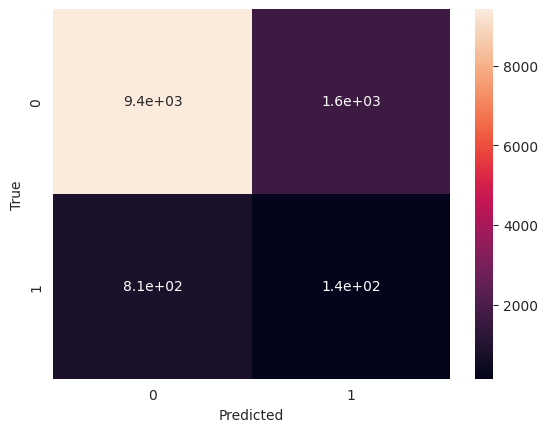

In [ ]:
sns.heatmap(confusion_matrix(y_valid, preds), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True');

In [ ]:
preds = preds.numpy()

In [ ]:
preds

array([ True, False, False, ..., False,  True, False])

In [ ]:
unique_values, counts = np.unique(preds, return_counts=True)

# 고유한 값들과 그 개수 출력
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: False, Count: 8356
Value: True, Count: 3645


In [ ]:
3645 / 8356

0.4362134992819531

In [ ]:
#TensorFlow의 Model 클래스를 기반으로 커스텀 모델인 AnomalyDetector를 정의
class AnomalyDetector(Model):

    def __init__(self):
        #상위 클래스인 Model 클래스의 생성자 호출
        super(AnomalyDetector, self).__init__()

        ## Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu", activity_regularizer=regularizers.l1(10e-5)),
            layers.Dense(16, activation="relu"),
            layers.Dense(2, activation="relu")
        ])

        ## Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(17, activation="sigmoid")  #출력층
        ])

    ##forward pass 정의
    def call(self, x):
        #입력 x를 인코더에 전달하여 인코딩된 특성을 추출
        encoded = self.encoder(x)
        #인코딩된 특성을 디코더에 전달하여 디코딩된 출력을 생성
        decoded = self.decoder(encoded)
        return decoded


model_name = "anomaly.h5"
## ModelCheckpoint: 'val_loss'를 모니터링해, 이 값이 개선될 때마다 모델 가중치 저장
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",  #모니터링할 지표
                            mode="min",  #모델을 저장할 때 val_loss를 최소화하도록 설정
                            save_best_only = True,  #val_loss가 감소할 때만 모델을 저장
                            save_weights_only=True,  #모델 아키텍처와 관련된 정보를 저장하지 않고 모델 가중치만 저장
                            verbose=0)  #모델 저장 과정을 화면에 출력


## Early Stopping: 검증 손실값이 5에폭 동안 향상이 없으면 조기 종료
earlystopping = EarlyStopping(monitor='val_loss',  #모니터링할 지표
                              min_delta = 0,  #개선으로 간주하기 위한 최소 변화량
                              patience = 8,  #val_loss가 개선되지 않더라도 몇 번의 epoch를 기다릴지
                              verbose = 1,  #조기 종료 과정을 화면에 출력
                              restore_best_weights=True)  #조기 종료 후 최상의 성능을 보인 모델 가중치로 복원


## 체크포인트와 조기 종료 콜백을 저장한다
callbacks = [checkpoint, earlystopping]

autoencoder = AnomalyDetector()


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)
autoencoder.compile(optimizer=optimizer, loss='mae')


history = autoencoder.fit(normal_X_train, normal_X_train,
          epochs=150,
          batch_size=128,
          validation_data=(X_valid, X_valid),
          callbacks = callbacks,
          shuffle=False)

Epoch 1/150
775/775 [==============================] - 8s 4ms/step - loss: 0.5675 - val_loss: 0.4474
Epoch 2/150
775/775 [==============================] - 2s 3ms/step - loss: 0.4446 - val_loss: 0.4439
Epoch 3/150
775/775 [==============================] - 2s 3ms/step - loss: 0.4428 - val_loss: 0.4429
Epoch 4/150
775/775 [==============================] - 2s 3ms/step - loss: 0.4395 - val_loss: 0.4368
Epoch 5/150
775/775 [==============================] - 2s 3ms/step - loss: 0.4321 - val_loss: 0.4285
Epoch 6/150
775/775 [==============================] - 2s 3ms/step - loss: 0.4243 - val_loss: 0.4201
Epoch 7/150
775/775 [==============================] - 3s 4ms/step - loss: 0.4152 - val_loss: 0.4102
Epoch 8/150
775/775 [==============================] - 3s 4ms/step - loss: 0.4053 - val_loss: 0.4007
Epoch 9/150
775/775 [==============================] - 2s 3ms/step - loss: 0.3970 - val_loss: 0.3933
Epoch 10/150
775/775 [==============================] - 2s 3ms/step - loss: 0.3914 - val_lo